## 1. 49999 New York taxi trips
<p><img style="float: right;margin:5px 20px 5px 1px; max-width:300px" src="https://assets.datacamp.com/production/project_496/img/taxi.jpg"> To drive a yellow New York taxi, you have to hold a "medallion" from the city's <em>Taxi and Limousine Commission</em>. Recently, one of those changed hands for over one million dollars, which shows how lucrative the job can be.</p>
<p>But this is the age of business intelligence and analytics! Even taxi drivers can stand to benefit from some careful investigation of the data, guiding them to maximize their profits. In this project, we will analyze a random sample of 49999 New York journeys made in 2013. We will also use regression trees and random forests to build a model that can predict the locations and times when the biggest fares can be earned.</p>
<p>Let's start by taking a look at the data!</p>

In [88]:
# Loading the tidyverse
library(tidyverse)

# Reading in the taxi data
taxi <- read_csv('datasets/taxi.csv')

# Taking a look at the first few rows in taxi
head(taxi,10)

Parsed with column specification:
cols(
  medallion = col_character(),
  pickup_datetime = col_datetime(format = ""),
  pickup_longitude = col_double(),
  pickup_latitude = col_double(),
  trip_time_in_secs = col_double(),
  fare_amount = col_double(),
  tip_amount = col_double()
)


medallion,pickup_datetime,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount
4D24F4D8EF35878595044A52B098DFD2,2013-01-13 10:23:00,-73.94646,40.77273,600,8.0,2.5
A49C37EB966E7B05E69523D1CB7BE303,2013-01-13 04:52:00,-73.99827,40.74041,840,18.0,0.0
1E4B72A8E623888F53A9693C364AC05A,2013-01-13 10:47:00,-73.95346,40.77586,60,3.5,0.7
F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13 11:14:00,-73.98137,40.72473,720,11.5,2.3
A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13 11:24:00,-73.96800,40.76000,240,6.5,0.0
19BF1BB516C4E992EA3FBAEDA73D6262,2013-01-13 10:51:00,-73.98502,40.76341,540,8.5,1.7
5F2EFC03B544635C9B0E7A4AA4FF9AC3,2013-01-13 12:53:00,-73.97295,40.79527,0,2.5,0.0
8DEB70907D00AA1D7FF5E2683240549B,2013-01-13 07:59:00,-73.96577,40.76530,120,4.0,0.0
E15F7CCB808DD15E0496D830D3DEDECE,2013-01-13 08:09:00,-73.94768,40.77507,720,14.0,2.0
0B3D3D51C78E944F68DC04209E86D5F7,2013-01-13 12:53:00,-73.98457,40.72488,180,4.0,3.0


## 2. Cleaning the taxi data
<p>As you can see above, the <code>taxi</code> dataset contains the times and price of a large number of taxi trips. Importantly we also get to know the location, the longitude and latitude, where the trip was started.</p>
<p>Cleaning data is a large part of any data scientist's daily work. It may not seem glamorous, but it makes the difference between a successful model and a failure. The <code>taxi</code> dataset needs a bit of polishing before we're ready to use it.</p>

In [89]:
# Renaming the location variables,
# dropping any journeys with zero fares and zero tips,
# and creating the total variable as the log sum of fare and tip

taxi <- taxi %>% dplyr::rename("lat"="pickup_latitude","long"="pickup_longitude") %>% 
filter(fare_amount>0|tip_amount>0) %>% mutate(total=log(fare_amount+tip_amount)) 




## 3. Zooming in on Manhattan
<p>While the dataset contains taxi trips from all over New York City, the bulk of the trips are to and from Manhattan, so let's focus only on trips initiated there.</p>

In [91]:
# Reducing the data to taxi trips starting in Manhattan
# Manhattan is bounded by the rectangle with 
# latitude from 40.70 to 40.83 and 
# longitude from -74.025 to -73.93
taxi <- taxi  %>% 
    filter(between(lat, 40.70, 40.83)&between(long,-74.025,-73.93))

## 4. Where does the journey begin?
<p>It's time to draw a map! We're going to use the excellent <code>ggmap</code> package together with <code>ggplot2</code> to visualize where in Manhattan people tend to start their taxi journeys.</p>

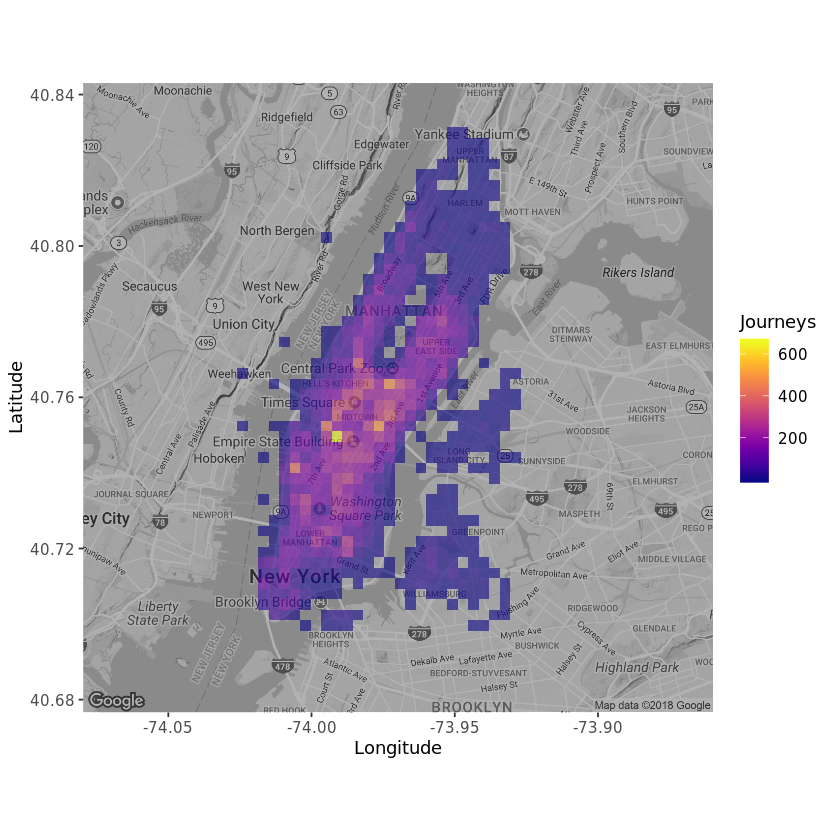

In [94]:
# Loading in ggmap and viridis for nice colors
library(ggmap)
library(viridis)

# Retrieving a stored map object which originally was created by
# manhattan <- get_map("manhattan", zoom = 12, color = "bw")
manhattan <- readRDS("datasets/manhattan.rds")

# Drawing a density map with the number of journey start locations
ggmap(manhattan, darken = 0.3) +
   scale_fill_viridis(option = 'plasma') + geom_bin2d(data=taxi, aes(x=long, y=lat),bins=60, alpha=0.6) +
labs(x='Longitude', y='Latitude', fill='Journeys')


## 5. Predicting taxi fares using a tree
<p>The map from the previous task showed that the journeys are highly concentrated in the business and tourist areas. We also see that some taxi trips originating in Brooklyn slipped through, but that's fine. </p>
<p>We're now going to use a regression tree to predict the <code>total</code> fare with <code>lat</code> and <code>long</code> being the predictors. The <code>tree</code> algorithm will try to find cutpoints in those predictors that results in the decision tree with the best predictive capability.  </p>

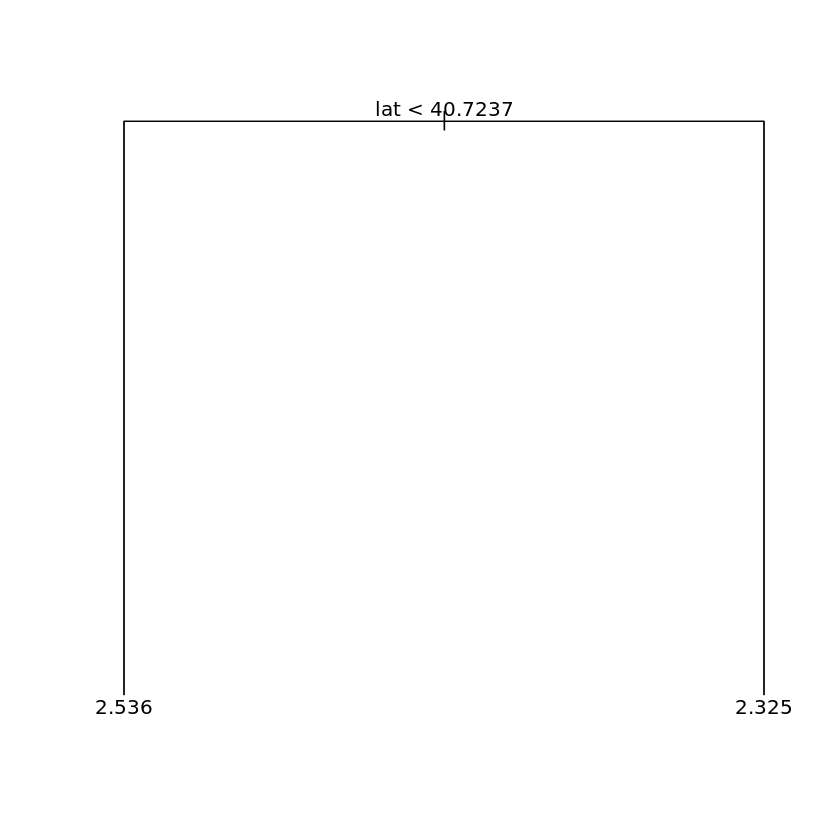

In [106]:
library(tree)
# Fitting a tree to lat and long
fitted_tree <- tree(total ~ lat+long, data=taxi)

plot(fitted_tree)
text(fitted_tree)

## 6. It's time. More predictors.
<p>The tree above looks a bit frugal, it only includes one split: It predicts that trips where <code>lat &lt; 40.7237</code> are more expensive, which makes sense as it is downtown Manhattan. But that's it. It didn't even include <code>long</code> as <code>tree</code> deemed that it didn't improve the predictions. Taxi drivers will need more information than this and any driver paying for your data-driven insights would be disappointed with that. As we know from Robert de Niro, it's best not to upset New York taxi drivers.</p>
<p>Let's start by adding some more predictors related to the <em>time</em> the taxi trip was made.</p>

In [119]:
# Loading in the lubridate package
library(lubridate)

# Generate the three new time variables
taxi <- taxi %>% 
    mutate(hour=hour(taxi$pickup_datetime),wday=wday(taxi$pickup_datetime, label=TRUE),month=month(taxi$pickup_datetime,label=TRUE))
head(taxi,5)

medallion,pickup_datetime,long,lat,trip_time_in_secs,fare_amount,tip_amount,total,hour,wday,month
4D24F4D8EF35878595044A52B098DFD2,2013-01-13 10:23:00,-73.94646,40.77273,600,8.0,2.5,2.351375,10,Sun,Jan
A49C37EB966E7B05E69523D1CB7BE303,2013-01-13 04:52:00,-73.99827,40.74041,840,18.0,0.0,2.890372,4,Sun,Jan
1E4B72A8E623888F53A9693C364AC05A,2013-01-13 10:47:00,-73.95346,40.77586,60,3.5,0.7,1.435085,10,Sun,Jan
F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13 11:14:00,-73.98137,40.72473,720,11.5,2.3,2.624669,11,Sun,Jan
A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13 11:24:00,-73.96800,40.76000,240,6.5,0.0,1.871802,11,Sun,Jan


## 7. One more tree!
<p>Let's try fitting a new regression tree where we include the new time variables.</p>


Regression tree:
tree(formula = total ~ lat + long + hour + wday + month, data = taxi)
Variables actually used in tree construction:
[1] "lat"
Number of terminal nodes:  2 
Residual mean deviance:  0.3041 = 13910 / 45760 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.61900 -0.37880 -0.04244  0.00000  0.32660  2.69900 

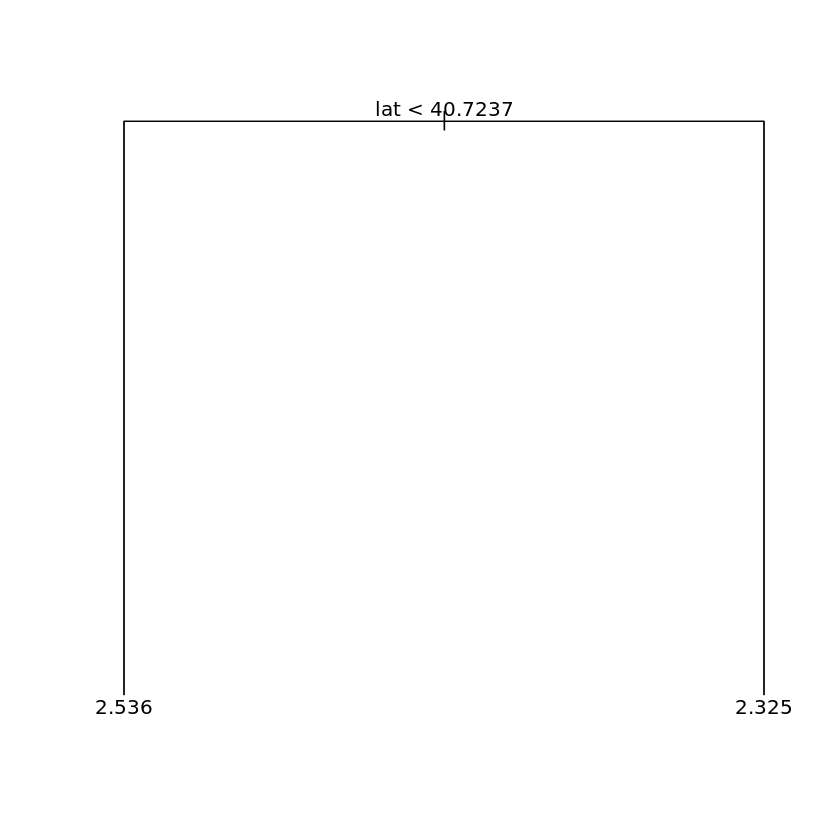

In [120]:
# Fitting a tree with total as the outcome and 
# lat, long, hour, wday, and month as predictors
fitted_tree <- tree(total ~ lat+long+hour+wday+month, taxi)

plot(fitted_tree)
text(fitted_tree)
# Summarizing the performance of the tree
summary(fitted_tree)



## 8. One tree is not enough
<p>The regression tree has not changed after including the three time variables. This is likely because latitude is still the most promising first variable to split the data on, and after that split, the other variables are not informative enough to be included. A random forest model, where many different trees are fitted to subsets of the data, may well include the other variables in some of the trees that make it up. </p>

In [122]:
library(randomForest)

# Fitting a random forest
fitted_forest <- randomForest(total ~ lat + long + hour + wday + month,
    data=taxi, ntree=80, sampsize=10000)

fitted_forest
taxi


Call:
 randomForest(formula = total ~ lat + long + hour + wday + month,      data = taxi, ntree = 80, sampsize = 10000) 
               Type of random forest: regression
                     Number of trees: 80
No. of variables tried at each split: 1

          Mean of squared residuals: 0.2994557
                    % Var explained: 2.88

medallion,pickup_datetime,long,lat,trip_time_in_secs,fare_amount,tip_amount,total,hour,wday,month
4D24F4D8EF35878595044A52B098DFD2,2013-01-13 10:23:00,-73.94646,40.77273,600,8.0,2.50,2.3513753,10,Sun,Jan
A49C37EB966E7B05E69523D1CB7BE303,2013-01-13 04:52:00,-73.99827,40.74041,840,18.0,0.00,2.8903718,4,Sun,Jan
1E4B72A8E623888F53A9693C364AC05A,2013-01-13 10:47:00,-73.95346,40.77586,60,3.5,0.70,1.4350845,10,Sun,Jan
F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13 11:14:00,-73.98137,40.72473,720,11.5,2.30,2.6246686,11,Sun,Jan
A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13 11:24:00,-73.96800,40.76000,240,6.5,0.00,1.8718022,11,Sun,Jan
19BF1BB516C4E992EA3FBAEDA73D6262,2013-01-13 10:51:00,-73.98502,40.76341,540,8.5,1.70,2.3223877,10,Sun,Jan
5F2EFC03B544635C9B0E7A4AA4FF9AC3,2013-01-13 12:53:00,-73.97295,40.79527,0,2.5,0.00,0.9162907,12,Sun,Jan
8DEB70907D00AA1D7FF5E2683240549B,2013-01-13 07:59:00,-73.96577,40.76530,120,4.0,0.00,1.3862944,7,Sun,Jan
E15F7CCB808DD15E0496D830D3DEDECE,2013-01-13 08:09:00,-73.94768,40.77507,720,14.0,2.00,2.7725887,8,Sun,Jan
0B3D3D51C78E944F68DC04209E86D5F7,2013-01-13 12:53:00,-73.98457,40.72488,180,4.0,3.00,1.9459101,12,Sun,Jan


## 9. Plotting the predicted fare
<p>In the output of <code>fitted_forest</code> you should see the <code>Mean of squared residuals</code>, that is, the average of the squared errors the model makes. If you scroll up and check the <code>summary</code> of <code>fitted_tree</code> you'll find <code>Residual mean deviance</code> which is the same number. If you compare these numbers, you'll see that <code>fitted_forest</code> has a slightly lower error. Neither predictive model is <em>that</em> good, in statistical terms, they explain only about 3% of the variance. </p>
<p>Now, let's take a look at the predictions of <code>fitted_forest</code> projected back onto Manhattan.</p>

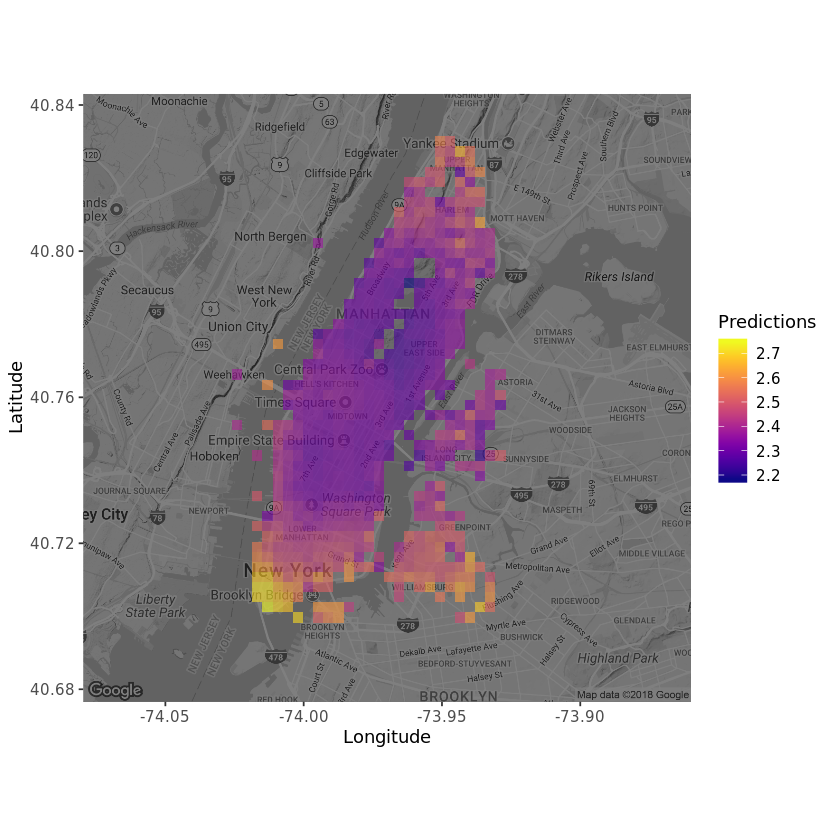

In [123]:
# Extracting the prediction from fitted_forest
taxi$pred_total <- fitted_forest$predicted

ggmap(manhattan, darken=0.5) +
    scale_fill_viridis(option = 'plasma') +
    stat_summary_2d(data=taxi, aes(x = long, y = lat, z = pred_total),
                    fun = mean, alpha = 0.6, bins = 60) +
    labs(x = 'Longitude', y = 'Latitude', fill = 'Predictions')


## 10. Plotting the actual fare
<p>Looking at the map with the predicted fares we see that fares in downtown Manhattan are predicted to be high, while midtown is lower. This map only shows the prediction as a function of <code>lat</code> and <code>long</code>, but we could also plot the predictions over time, or a combination of time and space, but we'll leave that for another time.</p>
<p>For now, let's compare the map with the predicted fares with a new map showing the mean fares according to the data.</p>

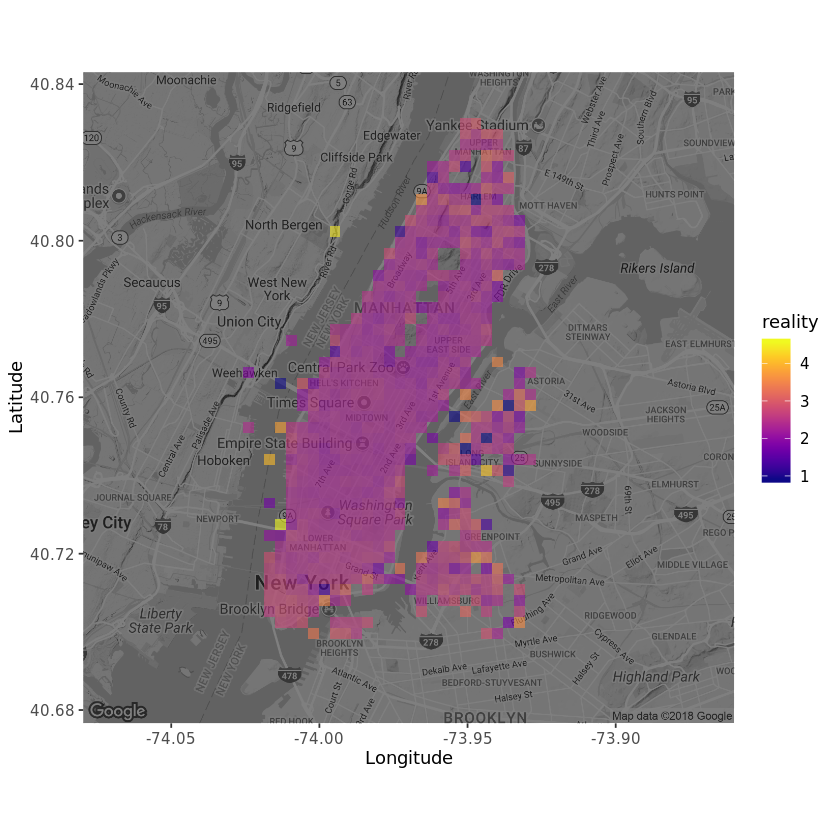

In [125]:
# Function that returns the mean *if* there are 15 or more datapoints
mean_if_enough_data <- function(x) { 
    ifelse( length(x) >= 15, mean(x), NA) 
}

ggmap(manhattan, darken=0.5)+
    scale_fill_viridis(option='plasma') +
    stat_summary_2d(data = taxi, aes(x = long, y = lat,z=total), bins = 60, alpha = 0.6,fun=mean) +
    labs(x='Longitude', y='Latitude', fill='reality')

## 11. Where  do people spend the most?
<p>So it looks like the random forest model captured some of the patterns in our data. At this point in the analysis, there are many more things we could do that we haven't done. We could add more predictors if we have the data. We could try to fine-tune the parameters of <code>randomForest</code>. And we should definitely test the model on a hold-out test dataset. But for now, let's be happy with what we have achieved!</p>
<p>So, if you are a taxi driver in NYC, where in Manhattan would you expect people to spend the most on a taxi ride?</p>

In [0]:
# Where are people spending the most on their taxi trips?
spends_most_on_trips <- "...." # "uptown" or "downtown"